<a href="https://colab.research.google.com/github/lsh3163/styletransfer/blob/master/keras(8_3)styletrans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/lsh3163/styletransfer/archive/master.zip

--2018-11-03 03:51:06--  https://github.com/lsh3163/styletransfer/archive/master.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/lsh3163/styletransfer/zip/master [following]
--2018-11-03 03:51:06--  https://codeload.github.com/lsh3163/styletransfer/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.253.121, 192.30.253.120
Connecting to codeload.github.com (codeload.github.com)|192.30.253.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [  <=>               ] 144.11K   571KB/s    in 0.3s    

2018-11-03 03:51:07 (571 KB/s) - ‘master.zip’ saved [147567]



In [2]:
!unzip master.zip

Archive:  master.zip
b0f3137e7c4bf2cbce9476aad322425105e2368d
   creating: styletransfer-master/
 extracting: styletransfer-master/README.md  
  inflating: styletransfer-master/content.JPG  
  inflating: styletransfer-master/style.JPG  


In [0]:
!mv styletransfer-master/content.JPG ./
!mv styletransfer-master/style.JPG ./

In [4]:
!ls

content.JPG  master.zip  sample_data  style.JPG  styletransfer-master


In [6]:
import tensorflow as tf
print(tf.__version__)

1.12.0-rc2


# 8.3 뉴럴 스타일 트랜스퍼
## 현대 사진을 조선스타일로 그리기
**_Estimated completion time : 60 minutes_**

뉴럴 스타일 트랜스퍼(neural style transfer)는 타깃 이미지의 콘텐츠를 보존하면서 참조 이미지의 스타일을 타깃 이미지에 적용시킨다.

### 8.3.1 콘텐츠 손실
네트워크의 하위 활성화는 국부적인 정보, 상위 층일 수록 점점 전역적이고 추상적인 정보를 담게 된다. 컨브넷 상위층의 표현으르 사용하면 추상적인 이미지 콘텐츠를 얻는다.

### 8.3.2 스타일 손실
사전 훈련된 컨브넷을 사용하여 다음 손실을 정의할 수 있다.
  1. 콘텐츠를 보존하기 위해 타깃 콘텐츠 이미지와 생성된 이미지 사이에서 상위 층의 활성화를 비슷하게 유지한다.
  2. 특성의 상관관계는 텍스처를 잡아낸다. 생성된 이미지와 스타일 참조 이미지는 여러 크기의 텍스처를 공유한다.

### 8.3.3 케라스에서 뉴럴 스타일 트랜스퍼 구현하기
일반적인 과정은 다음과 같다.
  1. 스타일 참조 이미지, 타깃 이미지, 생성된 이미지를 위해 VGG19의 층 활성화를 동시에 계산하는 네트워크를 설정한다.
  2. 세 이미지에서 계산한 층 활성화를 사용하여 손실 함수를 정의한다. 이 손실을 최소화하여 스타일 트랜스퍼를 구현한다.
  3. 손실 함수를 최소화할 경사 하강법 과정을 설정한다.

** 코드 8-14 ** 변수 초기값 정의하기

In [0]:
from keras.preprocessing.image import load_img, img_to_array

target_image_path = './style.JPG'
style_reference_image_path = './content.JPG'

width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [0]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    x = x[:,:,::-1]
    x = np.clip(x,0,255).astype('uint8')
    return x

In [20]:
from keras import backend as K
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1,img_height,img_width,3))

input_tensor = K.concatenate([target_image,
                             style_reference_image,
                             combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                   weights='imagenet',
                   include_top=False)
print("모델 로드 완료")

모델 로드 완료


In [0]:
def content_loss(base, combination):
    return K.sum(K.square(combination-base))

In [0]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
    gram = K.dot(features, K.transpose(features))
    return gram
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S-C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height-1, :img_width-1,:] - 
        x[:,1:,:img_width-1,:])
    b = K.square(
        x[:,:img_height-1,:img_width-1,:] -
        x[:,:img_height-1,1:,:])
    return K.sum(K.pow(a+b,1.25))

In [0]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block5_conv2'

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',]

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]

loss += content_weight * content_loss(target_image_features, combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1,:,:,:]
    combination_features = layer_features[2,:,:,:]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl

loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1,img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    
evaluator = Evaluator()

In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

%matplotlib inline

In [27]:
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()
img_list = []
for i in range(iterations):
    print("반복 횟수",i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
    print("현재 손실 값:", min_val)
    img = x.copy().reshape((img_height,img_width,3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    # save_image(fname, deprocess_image(np.copy(img)))
    img_list.append(img)
    print("저장 이미지: ",fname)
    end_time = time.time()
    print("%d 번째 반복 완료: %ds" % (i,end_time-start_time))
# print(img_list)

반복 횟수 0
현재 손실 값: 7550259700.0
저장 이미지:  style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 21s
반복 횟수 1
현재 손실 값: 3660527900.0
저장 이미지:  style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 16s
반복 횟수 2
현재 손실 값: 2503268900.0
저장 이미지:  style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 16s
반복 횟수 3
현재 손실 값: 1950658800.0
저장 이미지:  style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 16s
반복 횟수 4
현재 손실 값: 1642887400.0
저장 이미지:  style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 16s
반복 횟수 5
현재 손실 값: 1432596900.0
저장 이미지:  style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 16s
반복 횟수 6
현재 손실 값: 1287572500.0
저장 이미지:  style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 16s
반복 횟수 7
현재 손실 값: 1179602700.0
저장 이미지:  style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 16s
반복 횟수 8
현재 손실 값: 1086866800.0
저장 이미지:  style_transfer_result_at_iteration_8.png
8 번째 반복 완료: 16s
반복 횟수 9
현재 손실 값: 1007066100.0
저장 이미지:  style_transfer_result_at_iteration_9.png
9 번째 반복 완료: 16s
반복 횟수 10
현재 손실 값: 934426500.0
저장 이미지:  s

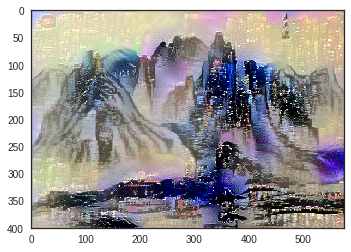

In [28]:
import seaborn as sns
with sns.axes_style("white"):
    plt.imshow(img_list[iterations-1])
# imshow(img_list[iterations-1], grid=False)

In [6]:
import keras as k
print(k.__version__)

2.1.6


In [5]:
import tensorflow as tf
print(tf.__version__)

1.12.0-rc2
